In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

import tqdm

%matplotlib inline

import sherlock # eset kivizsgalo szimulator

In [2]:
df =  pd.read_csv("./Dataset_Anomaly_Init_R2.csv") # dataset
sec = pd.read_csv("./Dataset_Anomaly_Secret_R2.csv") # megoldas

In [3]:
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,ID
0,8,10,12,8,9,10,6,2,5,9,5,7,8,7,2,8,0
1,4,2,5,3,3,8,6,6,4,6,7,8,7,6,2,6,1
2,2,0,3,1,1,7,8,4,0,7,8,8,7,9,0,8,2
3,2,3,3,2,2,7,9,5,4,7,6,7,5,9,2,7,3
4,5,9,8,7,5,7,9,2,4,10,5,6,5,9,1,7,4


In [4]:
df.shape

(2467, 17)

In [5]:
# odaadjuk az eset kivizsgalonak a megoldasokat es meghatarozunk egy budzset, ahanyszor kerdezhetunk toluk - 111
expert = sherlock.Sherlock(sec, 111)

# Szimuláció indul

# 1. etap - 9 változó + IsolationForest

In [6]:
bem_val=list(df.columns)[:9]

In [7]:
from sklearn.ensemble import IsolationForest

In [8]:
isoF = IsolationForest(random_state=42,
                       n_estimators=100,
                      )

In [9]:
isoF.fit(df[bem_val])

IsolationForest(random_state=42)

In [10]:
df['isoF_flag']=isoF.predict(df[bem_val])

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [11]:
df['isoF_flag']=isoF.fit_predict(df[bem_val])

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [12]:
df['isoF_flag'].value_counts()

 1    2037
-1     430
Name: isoF_flag, dtype: int64

In [13]:
df['isoF_score']=isoF.decision_function(df[bem_val])*-1

<AxesSubplot:>

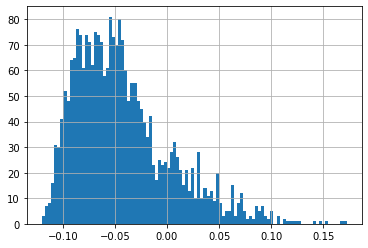

In [14]:
df['isoF_score'].hist(bins=100)

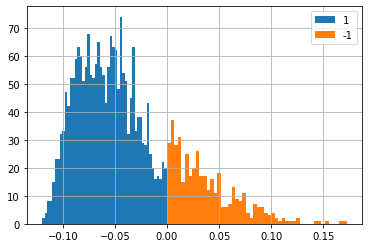

In [15]:
for i in [1,-1]:
    cdf = df[df['isoF_flag']==i]
    cdf['isoF_score'].hist(bins=50,label=str(i))
plt.legend()
    

In [16]:
gyanus = df.sort_values("isoF_score",ascending=False).head(10)

In [17]:
expert.stat()

Adathalmaz mérete   = 2467
Ismert esetek száma = 0 		max: 111


In [18]:
expert.investigate(gyanus['ID'])

	Nyomozás eredménye	2279	->	ok
	Nyomozás eredménye	2460	->	csalás
	Nyomozás eredménye	1106	->	csalás
	Nyomozás eredménye	950	->	ok
	Nyomozás eredménye	2367	->	ok
	Nyomozás eredménye	976	->	ok
	Nyomozás eredménye	1693	->	ok
	Nyomozás eredménye	2153	->	ok
	Nyomozás eredménye	2076	->	ok
	Nyomozás eredménye	2144	->	csalás


# 2. etap - 20 véletlen lemérése

In [19]:
expert.stat()

Adathalmaz mérete   = 2467
Ismert esetek száma = 10 		max: 111
  Ismert csalás = 3
  Felderítési arány = 30.0%


In [20]:
df = expert.add_label(df,'info')

In [21]:
df['info'].value_counts()

no_info    2457
ok            7
csalás        3
Name: info, dtype: int64

In [22]:
ismeretlen = df[df['info']=='no_info']

In [23]:
veletlenek = ismeretlen.sample(20,random_state=42)

In [24]:
expert.investigate(veletlenek['ID'])

	Nyomozás eredménye	719	->	ok
	Nyomozás eredménye	785	->	ok
	Nyomozás eredménye	1609	->	ok
	Nyomozás eredménye	867	->	ok
	Nyomozás eredménye	1086	->	ok
	Nyomozás eredménye	649	->	ok
	Nyomozás eredménye	1781	->	ok
	Nyomozás eredménye	651	->	ok
	Nyomozás eredménye	237	->	ok
	Nyomozás eredménye	736	->	ok
	Nyomozás eredménye	1292	->	ok
	Nyomozás eredménye	1274	->	ok
	Nyomozás eredménye	406	->	ok
	Nyomozás eredménye	521	->	ok
	Nyomozás eredménye	978	->	ok
	Nyomozás eredménye	353	->	ok
	Nyomozás eredménye	1389	->	ok
	Nyomozás eredménye	1173	->	ok
	Nyomozás eredménye	2284	->	ok
	Nyomozás eredménye	620	->	ok


In [25]:
df = expert.add_label(df,'info')
df['info'].value_counts()

no_info    2437
ok           27
csalás        3
Name: info, dtype: int64

# 3. etap - 10 valtozo + KMeans

In [26]:
bem_val = list(df.columns)[:10]

In [27]:
from sklearn.cluster import KMeans

In [28]:
kmeans = KMeans(random_state=42,n_clusters=11)

In [29]:
kmeans.fit(df[bem_val])

KMeans(n_clusters=11, random_state=42)

In [34]:
df['myc_dist']=kmeans.transform(df[bem_val]).min(axis=1)

<AxesSubplot:>

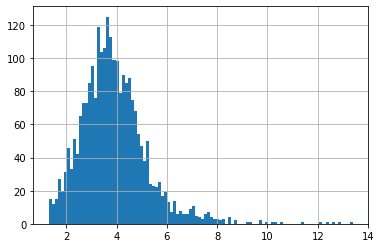

In [36]:
df['myc_dist'].hist(bins=100)

In [37]:
df['myc']=kmeans.predict(df[bem_val])

In [38]:
df['myc'].value_counts()

3     415
7     300
4     288
1     262
10    247
0     241
8     201
6     197
2     142
5      87
9      87
Name: myc, dtype: int64

In [39]:
stat = df.groupby('myc',as_index=False).agg({"myc_dist":"median"})

In [41]:
stat.columns=['myc','median_dist']

In [44]:
df = df.merge(stat,on='myc',how='left')

In [46]:
df['kmeans_score']=df['myc_dist']/df['median_dist']

<AxesSubplot:>

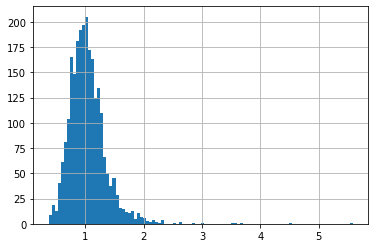

In [47]:
df['kmeans_score'].hist(bins=100)

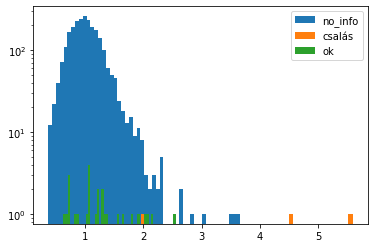

In [51]:
def score_plot(df,valtozo_nev):
    plt.yscale('log')
    for i in ['no_info','csalás','ok']:
        cdf = df[df['info']==i]
        plt.hist(cdf[valtozo_nev],bins=50,label=i)
    plt.legend()
    
score_plot(df,'kmeans_score')

In [55]:
def kiertekelo(df,score):
    ismeretlenek = df[df['info']=='no_info']
    gyanusak = ismeretlenek.sort_values(score,ascending=False).head(10)
    expert.investigate(gyanusak['ID'])
kiertekelo(df,'kmeans_score')

	Nyomozás eredménye	2399	->	csalás
	Nyomozás eredménye	629	->	csalás
	Nyomozás eredménye	2033	->	csalás
	Nyomozás eredménye	828	->	csalás
	Nyomozás eredménye	1069	->	csalás
	Nyomozás eredménye	1821	->	csalás
	Nyomozás eredménye	2009	->	csalás
	Nyomozás eredménye	908	->	csalás
	Nyomozás eredménye	1070	->	ok
	Nyomozás eredménye	2129	->	csalás


In [56]:
df = expert.add_label(df,'info')
expert.stat()

Adathalmaz mérete   = 2467
Ismert esetek száma = 40 		max: 111
  Ismert csalás = 12
  Felderítési arány = 30.0%


# 4. etap - 11 változó, logreg első fajta

In [57]:
df['info'].value_counts()

no_info    2427
ok           28
csalás       12
Name: info, dtype: int64

In [58]:
# Minden adaton tanulunk, de a "no_info" sorokat "ok"-nak nézzük

In [59]:
from sklearn.linear_model import LogisticRegression

In [64]:
logreg=LogisticRegression(random_state=42)

In [65]:
df['logreg_target']=df['info'].apply(lambda x: 1 if x=="csalás" else 0)

In [66]:
df['logreg_target'].value_counts()

0    2455
1      12
Name: logreg_target, dtype: int64

In [67]:
bem_val = list(df.columns)[:11]

In [68]:
logreg.fit(df[bem_val],df['logreg_target'])

LogisticRegression(random_state=42)

In [69]:
logreg.coef_

array([[-0.7793666 ,  0.02869624, -0.03580319, -0.39868619, -0.65360157,
        -0.87187706,  0.23292176,  0.16693943,  0.7780295 , -0.53566662,
        -0.06976612]])

In [70]:
df['logreg_score']=logreg.predict_proba(df[bem_val])[:,1]

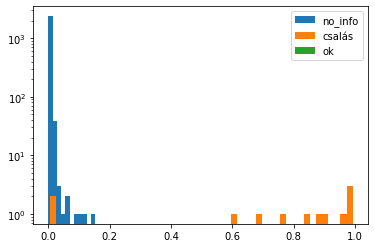

In [71]:
score_plot(df,'logreg_score')

In [72]:
kiertekelo(df,'logreg_score')

	Nyomozás eredménye	1049	->	csalás
	Nyomozás eredménye	676	->	csalás
	Nyomozás eredménye	1455	->	csalás
	Nyomozás eredménye	795	->	csalás
	Nyomozás eredménye	1592	->	csalás
	Nyomozás eredménye	593	->	csalás
	Nyomozás eredménye	929	->	csalás
	Nyomozás eredménye	1383	->	ok
	Nyomozás eredménye	507	->	csalás
	Nyomozás eredménye	2122	->	csalás


In [73]:
df = expert.add_label(df,'info')

In [74]:
expert.stat()

Adathalmaz mérete   = 2467
Ismert esetek száma = 50 		max: 111
  Ismert csalás = 21
  Felderítési arány = 42.0%


# Final - Rank áltlagolás

In [75]:
ujak = []
for score in ['isoF_score','kmeans_score','logreg_score']:
    df = df.sort_values(score,ascending=False)
    df = df.reset_index(drop=True)
    ujvaltozo=score+"_rank"
    df[ujvaltozo]=df.index
    ujak.append(ujvaltozo)

In [79]:
df['final_score']=df[ujak].mean(axis=1)

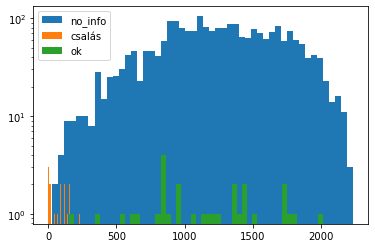

In [80]:
score_plot(df,'final_score')

In [81]:
expert.stat()

Adathalmaz mérete   = 2467
Ismert esetek száma = 50 		max: 111
  Ismert csalás = 21
  Felderítési arány = 42.0%


In [82]:
ismeretlenek = df[df['info']=='no_info']
gyanusak = ismeretlenek.sort_values('final_score').head(61)

In [83]:
expert.investigate(gyanusak['ID'])

	Nyomozás eredménye	1642	->	csalás
	Nyomozás eredménye	1942	->	csalás
	Nyomozás eredménye	1379	->	csalás
	Nyomozás eredménye	208	->	csalás
	Nyomozás eredménye	2361	->	csalás
	Nyomozás eredménye	269	->	ok
	Nyomozás eredménye	1719	->	ok
	Nyomozás eredménye	127	->	csalás
	Nyomozás eredménye	1047	->	csalás
	Nyomozás eredménye	1522	->	csalás
	Nyomozás eredménye	129	->	ok
	Nyomozás eredménye	948	->	csalás
	Nyomozás eredménye	1734	->	ok
	Nyomozás eredménye	1786	->	ok
	Nyomozás eredménye	83	->	ok
	Nyomozás eredménye	2043	->	ok
	Nyomozás eredménye	2143	->	ok
	Nyomozás eredménye	222	->	ok
	Nyomozás eredménye	2031	->	ok
	Nyomozás eredménye	1253	->	csalás
	Nyomozás eredménye	1184	->	ok
	Nyomozás eredménye	1542	->	csalás
	Nyomozás eredménye	997	->	csalás
	Nyomozás eredménye	244	->	csalás
	Nyomozás eredménye	684	->	csalás
	Nyomozás eredménye	958	->	ok
	Nyomozás eredménye	233	->	ok
	Nyomozás eredménye	480	->	ok
	Nyomozás eredménye	1756	->	ok
	Nyomozás eredménye	1512	->	csalás
	Nyomozás eredménye	610	

In [84]:
expert.stat()

Adathalmaz mérete   = 2467
Ismert esetek száma = 111 		max: 111
  Ismert csalás = 44
  Felderítési arány = 39.6%


# SZIMULACIO VEGE

In [86]:
sec['info'].value_counts()

ok          2326
anomalia     141
Name: info, dtype: int64

In [87]:
44/91

0.4835164835164835

In [88]:
141/len(df)

0.05715443858937981

In [89]:
lift = 0.4835164835164835 / 0.05715443858937981

In [90]:
lift

8.459823864079183